### 🔍 Anotações e Classes
Anotação batimento a batimento: Cada batimento cardíaco é anotado com:
- Tipo de batimento (classe)
- Localização temporal (sample)
- Informação auxiliar (marca de ruído, pausa, etc.)

### Principais classes de batimentos
Conforme a AAMI EC57 standard, os batimentos são frequentemente agrupados em:
- N: Batimentos normais
- S: Batimentos atriais (supraventriculares)
- V: Batimentos ventriculares
- F: Batimentos de fusão
- Q: Batimentos desconhecidos (ruídos, artefatos, etc.)

### Exemplos de rótulos específicos:
- N: Normal beat
- L: Left bundle branch block beat
- R: Right bundle branch block beat
- A: Atrial premature beat
- V: Premature ventricular contraction
- F: Fusion of ventricular and normal beat
- e, j, /, x, etc.: Outras anotações específicas ou ruídos

### Formatos de arquivo
- .dat: Sinais brutos em formato binário
- .hea: Arquivo de cabeçalho com metadados (ex: canais, frequências)
- .atr: Arquivos com anotações (batimentos e eventos)

### Ferramentas recomendadas para leitura:
- WFDB (WaveForm DataBase) toolkit
- Bibliotecas Python como wfdb e biosppy

### Dataset:
MIT-BIH:
- https://www.physionet.org/content/mitdb/1.0.0/

In [ ]:
# Importando bibliotecas
import wfdb
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Função para imprimir um intervalo de x segundos do eletrocardiograma
def plot_ecg(nome_registro, sinal_ecg, fs, duracao, n_amostras, info="", qrs_peaks=None):
    # Recorte do sinal e do tempo
    sinal_ds = sinal_ecg[:n_amostras]
    tempo_ds = np.arange(n_amostras) / fs

    # atualizando título para caso queira descrever o filtro utilizado
    titulo = f'ECG do Paciente {nome_registro} - MLII ({duracao} segundos)'
    if info != "":
        titulo += f' [{info}]'

    # Plotando dados
    plt.figure(figsize=(12, 4))
    plt.plot(tempo_ds, sinal_ds)

    if qrs_peaks is not None:
        picos_filtrados = [peak for peak in qrs_peaks if peak < n_amostras]
        tempos_picos = np.array(picos_filtrados) / fs

        for t in tempos_picos:
            plt.axvline(x=t, color='red', linestyle='--')

        plt.plot(tempos_picos, sinal_ds[picos_filtrados], 'ro')

    plt.title(titulo)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude (mV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Filtro passa banda
def band_pass(ecg, fs):
    W1 = 5*2/fs
    W2 = 15*2/fs
    b, a = signal.butter(4, [W1,W2], 'bandpass') # definindo parametros
    ecg_bp = signal.filtfilt(b,a,np.transpose(ecg)) # implementando filtro

    return ecg_bp

In [ ]:
# Diferenciação e elevação ao quadrado do sinal
def differentiate(ecg):
    ecg_df = np.diff(ecg)
    ecg_sq = np.power(ecg_df, 2)
    return np.insert(ecg_sq,0,ecg_sq[0]) # para manter o tamanho do array

In [ ]:
# Janela de média móvel
def moving_average(ecg,n=30):
    window  = np.ones((1,n))/n
    ECG_ma  = np.convolve(np.squeeze(ecg),np.squeeze(window), mode='same')
    return ECG_ma 

In [ ]:
# Função para encontrar os picos QRS
def find_qrs_peaks(ecg, fs, distancia=0.200):
    qrs_peaks, _  = signal.find_peaks(ecg, height=np.mean(ecg), distance=round(fs*distancia))
    return qrs_peaks

In [ ]:
# Função que calcula a frequência cardíaca a partir dos picos QRS
def frequencia_cardiaca_RR(qrs_picos, fs):
    qrs_tempo = qrs_picos / fs

    rr_intervalos = np.diff(qrs_tempo)
    rr_medio = np.mean(rr_intervalos)
    freq_cardiaca = 60 / rr_medio

    return freq_cardiaca


In [ ]:
# Código do paciente
nome_registro = "212"
base_de_dados = "mitdb"

try:
    registro = wfdb.rdrecord(nome_registro, pn_dir=base_de_dados)
    anotacoes = wfdb.rdann(nome_registro, 'atr', pn_dir=base_de_dados)

    print(f"registro = {registro}")
    print(f"anotacoes = {anotacoes}")
except FileNotFoundError:
    print(f"Arquivo não encontrado: {nome_registro}")
except Exception as e:
    print(f"Erro: {e}")

registro = <wfdb.io.record.Record object at 0x000001EBE6291BE0>
anotacoes = <wfdb.io.annotation.Annotation object at 0x000001EBE6291E80>


In [ ]:
print(f"Paciente: {registro.record_name}")
print(f"Duração: {registro.sig_len / registro.fs:.2f} segundos")
print(f"Número de canais: {registro.n_sig}")
print(f"Canais: {registro.sig_name}")
print(f"Frequência de amostragem: {registro.fs} Hz")
print(f"Unidades: {registro.units}")
print(f"Ganho do ADC: {registro.adc_gain}")
print(f"Resolução do ADC: {registro.adc_res} bits")

# Comentários clínicos (às vezes contém idade, sexo, etc.)
if registro.comments:
    print("\nComentários:")
    for c in registro.comments:
        print("-", c)

Paciente: 212
Duração: 1805.56 segundos
Número de canais: 2
Canais: ['MLII', 'V1']
Frequência de amostragem: 360 Hz
Unidades: ['mV', 'mV']
Ganho do ADC: [200.0, 200.0]
Resolução do ADC: [11, 11] bits

Comentários:
- 32 F 2879 171 x1
- None
- There is rate-related right bundle branch block which appears when the heart
- rate exceeds approximately 90 bpm.


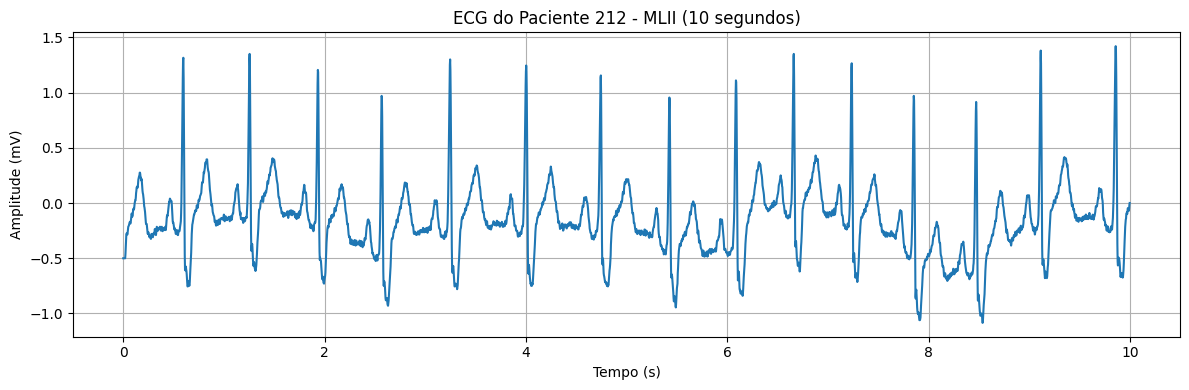

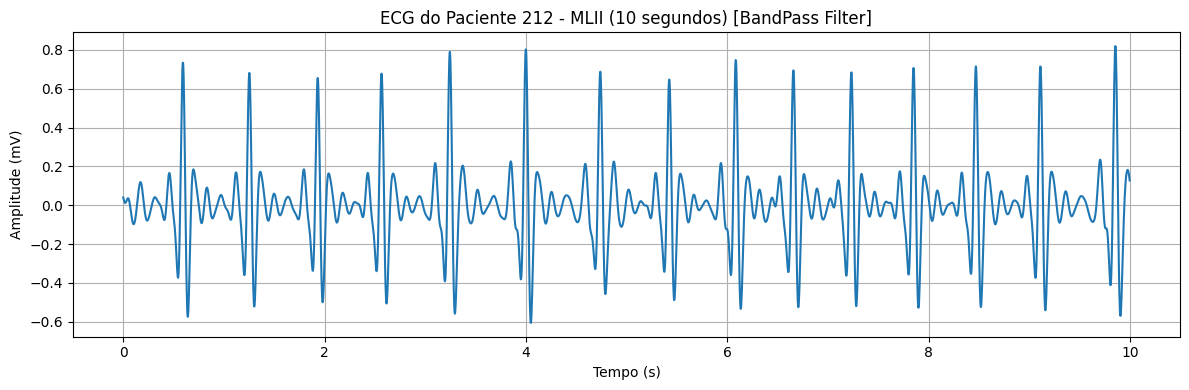

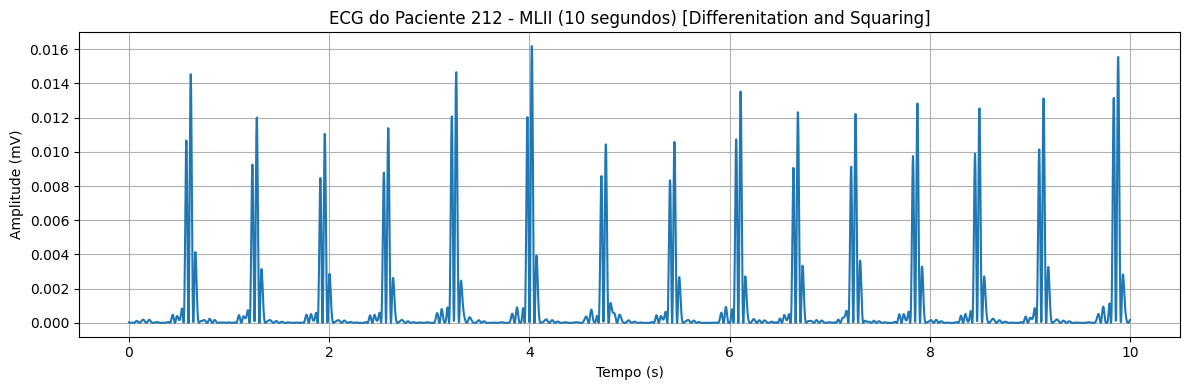

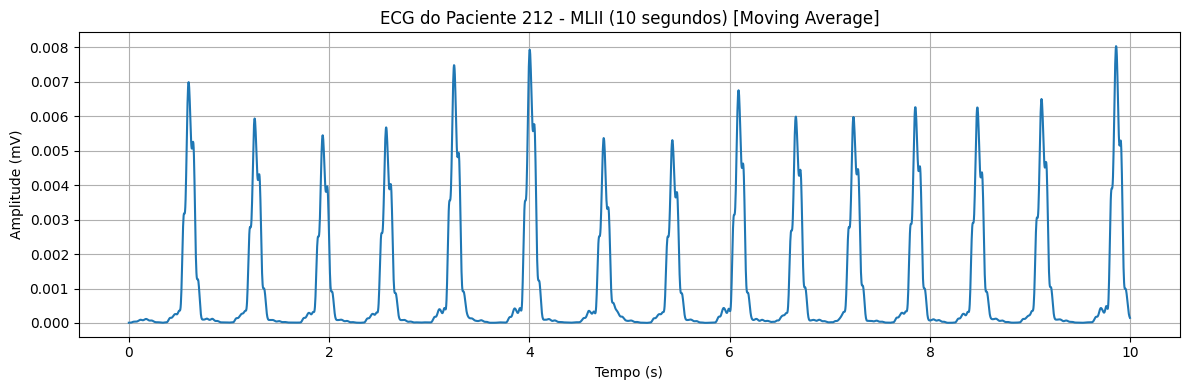

In [ ]:
# Carregando o sinal do ecg [canal 0: "MLII"] e sua frequência de amostragem
sinal_ecg = registro.p_signal[:, 0]
fs = registro.fs

# Duração desejada em segundos
duracao = 10
n_amostras = int(fs * duracao)

# Aplicando etapas do Pan-Tompkins
bp_sinal_ecg = band_pass(sinal_ecg, fs)
dif_sinal_ecg = differentiate(bp_sinal_ecg)
ma_sinal_ecg = moving_average(dif_sinal_ecg)

# Plotando sinais
plot_ecg(nome_registro, sinal_ecg, fs, duracao, n_amostras)
plot_ecg(nome_registro, bp_sinal_ecg, fs, duracao, n_amostras, info="BandPass Filter")
plot_ecg(nome_registro, dif_sinal_ecg, fs, duracao, n_amostras, info="Differenitation and Squaring")
plot_ecg(nome_registro, ma_sinal_ecg, fs, duracao, n_amostras, info="Moving Average")

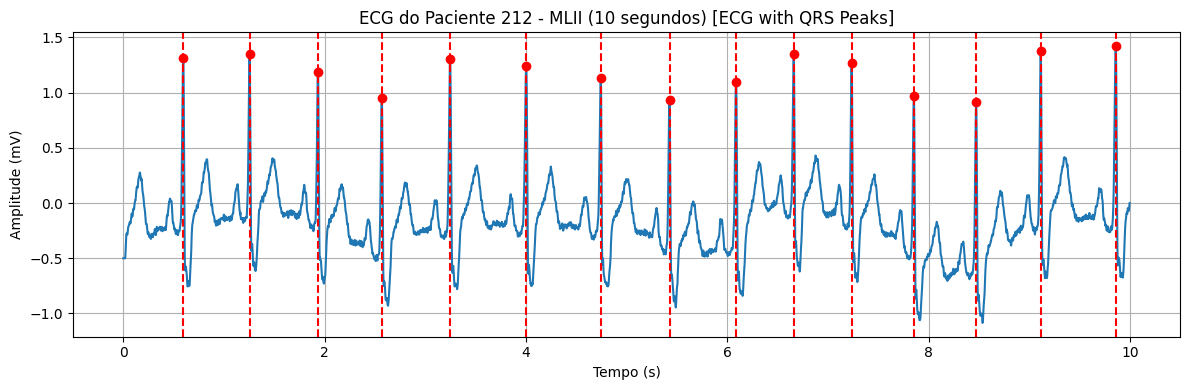

Frequência cardíaca do paciente 212: 91.32 bpm


In [ ]:
# Aplicando 
qrs_peaks = find_qrs_peaks(ma_sinal_ecg, fs)
fc = frequencia_cardiaca_RR(qrs_peaks, fs)

plot_ecg(nome_registro, sinal_ecg, fs, duracao, n_amostras, info="ECG with QRS Peaks", qrs_peaks=qrs_peaks)
print(f"Frequência cardíaca do paciente {nome_registro}: {fc:.2f} bpm")

### Análise de Registros da Base de Dados MIT-BIH

Este script Python interage com a base de dados de Arritmia MIT-BIH do PhysioNet para extrair informações detalhadas de cada registro de ECG.

**O que o código faz:**

1.  **Acessa a Base de Dados**: Conecta-se à base de dados MIT-BIH no PhysioNet.
2.  **Processa Cada Registro**: Para cada registro de ECG (paciente), ele:
    * Lê o sinal do ECG e suas anotações (onde cada batimento é classificado).
    * Calcula a duração total do registro e a frequência de amostragem.
    * Estima a frequência cardíaca média em batimentos por minuto (bpm).
    * Identifica os canais de gravação utilizados.
    * Extrai comentários associados ao registro (como idade e sexo do paciente).
    * **Conta os tipos específicos de batimentos cardíacos** presentes no registro.
3.  **Gera um Arquivo Excel**: Cria um arquivo chamado `dados_ecg_com_rotulos.xlsx` com uma tabela resumida contendo todas essas informações para cada registro processado.

**Significado das colunas de Contagem de Rótulos na Tabela:**

As colunas finais da tabela (`N`, `L`, `R`, `A`, `V`, `F`) representam a **quantidade de cada tipo de batimento cardíaco** detectado no registro. Esses rótulos são anotações padronizadas para classificar a morfologia e a origem dos batimentos no ECG:

* **N**: Batimento **Normal**. O impulso elétrico se origina e se propaga de forma saudável.
* **L**: Batimento de **Bloqueio do Ramo Esquerdo**. O impulso elétrico encontra um atraso na condução para o ventrículo esquerdo.
* **R**: Batimento de **Bloqueio do Ramo Direito**. O impulso elétrico encontra um atraso na condução para o ventrículo direito.
* **A**: **Batimento Atrial Prematuro** (extra-sístole atrial). Um batimento extra que se origina nos átrios antes do tempo esperado.
* **V**: **Contração Ventricular Prematura** (extra-sístole ventricular). Um batimento extra que se origina nos ventrículos, com um QRS geralmente alargado e distorcido.
* **F**: Batimento de **Fusão**. Ocorre quando um impulso normal e um impulso ventricular prematuro ativam o coração ao mesmo tempo, resultando em um batimento "misto".

Essas contagens são cruciais para a análise da saúde cardíaca, permitindo identificar a prevalência de diferentes arritmias em cada paciente.

In [ ]:
import wfdb
import pandas as pd
import numpy as np

# Obter a lista de registros disponíveis na base MIT-BIH
registros = wfdb.get_record_list('mitdb')

# Diretório da base no PhysioNet
base_de_dados = "mitdb"

# Rótulos que queremos contar
rotulos_desejados = ['N', 'L', 'R', 'A', 'V', 'F']

# Lista de resultados
dados_pacientes = []

for nome_registro in registros:
    print(f"Processando: {nome_registro}")
    try:
        registro = wfdb.rdrecord(nome_registro, pn_dir=base_de_dados)
        anotacoes = wfdb.rdann(nome_registro, 'atr', pn_dir=base_de_dados)

        fs = registro.fs
        duracao = registro.sig_len / fs
        canais = ', '.join(registro.sig_name)
        comentarios = ' | '.join(registro.comments) if registro.comments else ''

        # Cálculo da frequência cardíaca média com base no intervalo RR
        r_peaks = np.array(anotacoes.sample) / fs
        if len(r_peaks) > 1:
            rr_intervalos = np.diff(r_peaks)
            fc_media = 60 / np.mean(rr_intervalos)
        else:
            fc_media = np.nan

        # Contar quantos batimentos há de cada tipo desejado
        contagem = {rot: 0 for rot in rotulos_desejados}
        for simbolo in anotacoes.symbol:
            if simbolo in contagem:
                contagem[simbolo] += 1

        # Adiciona tudo em uma linha da tabela
        dados_pacientes.append({
            'registro': nome_registro,
            'duracao_segundos': round(duracao, 2),
            'frequencia_amostragem_Hz': fs,
            'frequencia_cardiaca_media_bpm': round(fc_media, 2) if not np.isnan(fc_media) else 'Indisponível',
            'n_canais': registro.n_sig,
            'canais': canais,
            'comentarios': comentarios,
            **contagem
        })

    except Exception as e:
        print(f"Erro ao processar {nome_registro}: {e}")
        dados_pacientes.append({
            'registro': nome_registro,
            'duracao_segundos': 'Erro',
            'frequencia_amostragem_Hz': 'Erro',
            'frequencia_cardiaca_media_bpm': 'Erro',
            'n_canais': 'Erro',
            'canais': 'Erro',
            'comentarios': f'Erro: {e}'
        })

# Criar DataFrame e salvar como Excel
df = pd.DataFrame(dados_pacientes)
df.to_excel("dados_ecg_com_rotulos.xlsx", index=False)
print("\n✅ Arquivo 'dados_ecg_com_rotulos.xlsx' gerado com sucesso!")


: 